# Setup & Reading data

In [1]:
import pandas as pd
import numpy as np
import shap
from scipy.stats import chi2_contingency
from scipy.stats import entropy
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
# import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# import sensitivity_score
from sklearn.metrics import recall_score
# import precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
directory = 'crunchbase/'

# Data preparation

In [4]:
orgs = pd.read_csv(directory + 'organizations.csv', usecols=['uuid', 'name', 'country_code', 'state_code', 'roles', 'primary_role',
                                                                   'status', 'category_list', 'category_groups_list', 
                                                                   'founded_on', 'closed_on'])

acquisitions = pd.read_csv(directory + 'acquisitions.csv', usecols=['acquiree_uuid', 'acquired_on'])

rounds = pd.read_csv(directory + 'funding_rounds.csv', usecols=['org_uuid', 'state_code', 'investment_type', 'announced_on', 'raised_amount_usd',
                                                                'investor_count'])

ipos = pd.read_csv(directory + 'ipos.csv', usecols=['org_uuid', 'went_public_on'])

people = pd.read_csv(directory + 'people.csv', usecols=['uuid', 'name', 'gender', 'country_code', 'featured_job_title', 'featured_job_organization_name', 'featured_job_organization_uuid'])

jobs = pd.read_csv(directory + 'jobs.csv', usecols=['person_uuid', 'org_uuid', 'title', 'started_on', 'ended_on'])

In [5]:
def create_basis(rounds):
    basis = rounds[rounds['investment_type'].isin(['series_a', 'series_b', 'pre_seed', 'seed', 'angel'])] 
    basis = basis.drop_duplicates(subset=['org_uuid', 'investment_type'], keep='first')
    pivot_df = basis.pivot_table(
        index='org_uuid',
        columns='investment_type',
        values=['announced_on', 'raised_amount_usd', 'investor_count', 'state_code'],
        aggfunc={
            'announced_on': 'first', 
            'raised_amount_usd': 'sum', 
            'investor_count': 'sum', 
            'state_code': 'first',
        }
    )

    pivot_df.columns = [' '.join(col).strip() for col in pivot_df.columns.values]
    pivot_df = pivot_df.drop(columns='raised_amount_usd series_b')
    pivot_df = pivot_df.drop(columns='investor_count series_b')
    pivot_df.columns = pivot_df.columns.str.replace(' ', '_')
    pivot_df = pivot_df.reset_index()
    pivot_df[[ 'investor_count_angel', 'investor_count_pre_seed',
       'investor_count_seed', 'investor_count_series_a',
       'raised_amount_usd_angel', 'raised_amount_usd_pre_seed',
       'raised_amount_usd_seed', 'raised_amount_usd_series_a']] = pivot_df[[ 'investor_count_angel', 'investor_count_pre_seed',
       'investor_count_seed', 'investor_count_series_a',
       'raised_amount_usd_angel', 'raised_amount_usd_pre_seed',
       'raised_amount_usd_seed', 'raised_amount_usd_series_a']].fillna(0)
    
    print(len(pivot_df))
    pivot_df = pivot_df[pivot_df['raised_amount_usd_series_a'] != 0]
    print(len(pivot_df))
    pivot_df = pivot_df.sort_values(by='org_uuid', ascending=True)

    pivot_df['temp_series_a_month'] = pd.to_datetime(pivot_df['announced_on_series_a'])

    pivot_df['temp_series_a_month'] = pivot_df['temp_series_a_month'].dt.to_period('M')
    print(len(pivot_df))

    pivot_df = pivot_df[pivot_df['temp_series_a_month'] < '2019-05']
    print(len(pivot_df))

    pivot_df.drop(columns=['temp_series_a_month'], inplace=True)


    return pivot_df

In [6]:
def mergings_of_basics(orgs, ipos, basis, acquisitions):
    basis.set_index('org_uuid', inplace=True)

    orgs = orgs.drop_duplicates(subset=['uuid'], keep='first')
    orgs = orgs.rename(columns={'uuid': 'org_uuid'})
    orgs.sort_values(by='org_uuid', ascending=True)
    orgs.set_index('org_uuid', inplace=True)

    ipos = ipos.drop_duplicates(subset=['org_uuid'], keep='first')
    ipos.sort_values(by='org_uuid', ascending=True)
    ipos.set_index('org_uuid', inplace=True)

    acquisitions = acquisitions.drop_duplicates(subset=['acquiree_uuid'], keep='first')
    acquisitions = acquisitions.rename(columns={'acquiree_uuid': 'org_uuid'})
    acquisitions.sort_values(by='org_uuid', ascending=True)
    acquisitions.set_index('org_uuid', inplace=True)

    basis_plus_orgs = basis.join(orgs, on='org_uuid', how='inner')
    basis_plus_orgs_plus_ipos = basis_plus_orgs.join(ipos, on='org_uuid', how='left')
    final = basis_plus_orgs_plus_ipos.join(acquisitions, on='org_uuid', how='left')

    final = final.reset_index()

    to_datetime = ['announced_on_angel', 'announced_on_pre_seed', 'announced_on_seed', 'announced_on_series_a', 'announced_on_series_b', 'founded_on', 'closed_on', 'went_public_on', 'acquired_on']

    for col in to_datetime:
        final[col] = pd.to_datetime(final[col], errors='coerce')    

    return final

## Target variable

In [7]:
def shape_data(orgs, ipos, rounds, acquisitions):
    basis = create_basis(rounds)
    joined_data = mergings_of_basics(orgs, ipos, basis, acquisitions)

    # Create binary variable indicating whether the company has been acquired within 5 years after series A
    joined_data['acquired_within_5_years'] = (joined_data['acquired_on'] - joined_data['announced_on_series_a']) < pd.Timedelta(days=1825)
    joined_data['acquired_within_5_years'] = joined_data['acquired_within_5_years'].astype(int)

    # Create binary variable indicating whether the company has gone public within 5 years after series A
    joined_data['went_public_within_5_years'] = (joined_data['went_public_on'] - joined_data['announced_on_series_a']) < pd.Timedelta(days=1825)
    joined_data['went_public_within_5_years'] = joined_data['went_public_within_5_years'].astype(int)

    # Create binary variable indicating whether the company has reached series B within 5 years after series A
    joined_data['reached_series_b_within_5_years'] = (joined_data['announced_on_series_b'] - joined_data['announced_on_series_a']) < pd.Timedelta(days=1825)
    joined_data['reached_series_b_within_5_years'] = joined_data['reached_series_b_within_5_years'].astype(int)

    # Create binary variable indicating whether the company has been closed within 5 years after series A
    joined_data['closed_within_5_years'] = (joined_data['closed_on'] - joined_data['announced_on_series_a']) < pd.Timedelta(days=1825)
    joined_data['closed_within_5_years'] = joined_data['closed_within_5_years'].astype(int)

    joined_data.rename(columns={'reached_series_b_within_5_years': 'successful'}, inplace=True)

    joined_data.loc[joined_data['closed_within_5_years'] == 1, 'successful'] = 0
    joined_data.loc[joined_data['acquired_within_5_years'] == 1, 'successful'] = 1
    joined_data.loc[joined_data['went_public_within_5_years'] == 1, 'successful'] = 1

    # Drop columns that are no longer needed
    joined_data.drop(columns=['closed_on', 'closed_within_5_years', 'acquired_on', 'acquired_within_5_years', 'went_public_on', 'went_public_within_5_years'], inplace=True)

    joined_data.set_index('org_uuid', inplace=True)

    return joined_data


In [ ]:
df = shape_data(orgs, ipos, rounds, acquisitions)

In [ ]:
mapping_founding_dates = pd.read_csv(directory + 'funding_rounds.csv', usecols=['org_uuid', 'state_code', 'investment_type', 'announced_on', 'raised_amount_usd',
                                                                'investor_count'])

mapping_founding_dates = create_basis(mapping_founding_dates)

orgs_date = pd.read_csv(directory + 'organizations.csv', usecols=['uuid', 'founded_on'])
orgs_date.rename(columns={'uuid': 'org_uuid'}, inplace=True)

mapping_founding_dates = pd.merge(mapping_founding_dates, orgs_date, on='org_uuid', how='inner')

mapping_founding_dates = mapping_founding_dates[['org_uuid', 'announced_on_series_a', 'founded_on']]

In [10]:
def preprocess_jobs_people(df, people2, jobs2, mapping_founding_dates):
    jobs3 = pd.merge(jobs2, mapping_founding_dates, on='org_uuid', how='left')

    jobs3['is_founder'] = jobs3['title'].str.contains('founder', case=False, na=False).astype(int)

    jobs3.drop(columns=['title'], inplace=True)

    jobs3 = jobs3.loc[(jobs3['started_on'] <= jobs3['announced_on_series_a']) | jobs3['started_on'].isnull()]

    jobs3 = jobs3.loc[~(jobs3['ended_on'] <= jobs3['announced_on_series_a'])]

    # if started_on is NaN and person is not a founder, then drop observation
    jobs3 = jobs3.loc[~(jobs3['started_on'].isnull() & (jobs3['is_founder'] == 0))]

    jobs3.drop(columns=['started_on', 'ended_on'], inplace=True)

    jobs3.rename(columns={'person_uuid': 'uuid'}, inplace=True)

    # group by org_uuid and person uuid, if one of the "is_founder" is 1, then the person is a founder
    jobs3 = jobs3.groupby(['org_uuid', 'uuid']).agg({'is_founder': 'max'}).reset_index()

    # drop duplicates wrt uuid and org_uuid
    jobs3 = jobs3.drop_duplicates(subset=['org_uuid', 'uuid'], keep='first')

    # add column number of employees, accordingly group by org_uuid and count the number of employees. 
    jobs3['number_of_employees'] = jobs3.groupby('org_uuid')['uuid'].transform('count')

    # delete non-founder observations
    jobs3 = jobs3.loc[jobs3['is_founder'] == 1]

    df_merge = df.copy()

    df_merge = df_merge.reset_index()

    df_merge = pd.merge(jobs3, df_merge, on='org_uuid', how='left')

    # only keep columns org_uuid, uuid, successful, series a date, and number of employees
    df_merge = df_merge[['org_uuid', 'uuid', 'successful', 'announced_on_series_a', 'number_of_employees']]

    df_merge['number_of_companies_founded_before'] = df_merge.groupby('uuid')['announced_on_series_a'].rank(method='first') - 1

    df_merge_test = df_merge.copy()
    df_merge_test['number_of_successful_companies_founded_before'] = 0

    for founder, rows in df_merge.groupby('uuid'):
        # sort the group by the series a date
        rows = rows.sort_values(by='announced_on_series_a', ascending=True)
        for index, row in rows.iterrows():
            if row['number_of_companies_founded_before'] == 0:
                continue
            else:
                # get the number of successful companies founded before
                df_merge_test.loc[index, 'number_of_successful_companies_founded_before'] = rows.loc[rows['announced_on_series_a'] < row['announced_on_series_a'] - pd.DateOffset(years=5), 'successful'].sum()

    people2.drop(columns=['name', 'featured_job_title', 'featured_job_organization_name', 'featured_job_organization_uuid'], inplace=True)

    people_and_jobs = pd.merge(df_merge_test, people2, on=['uuid'], how='left')

    people_and_jobs['male_founders'] = (people_and_jobs['gender'] == 'male').astype(int)
    people_and_jobs['female_founders'] = (people_and_jobs['gender'] == 'female').astype(int)

    pj_test = pd.merge(people_and_jobs, mapping_founding_dates, on='org_uuid', how='left')

    pj_test.rename(columns={'uuid': 'founder_uuid', 'country_code': 'founders_country_code'}, inplace=True)

    pj_test.drop(columns=['announced_on_series_a_x', 'successful'], inplace=True)

    pj_test.set_index('founder_uuid', inplace=True)

    successes = pj_test.copy()

    successes.drop(columns=['gender', 'founders_country_code', 'male_founders', 'female_founders', 'announced_on_series_a_y', 'founded_on'], inplace=True)

    successes.columns

    successes['success_ratio'] = successes['number_of_successful_companies_founded_before'] / successes['number_of_companies_founded_before']

    successes.reset_index(inplace=True)

    successes = successes.drop(columns=['founder_uuid'])

    # lets aggregate this on a company level
    tesa = successes.groupby('org_uuid').agg({
    'number_of_employees': 'max',
    'number_of_companies_founded_before': ['mean', 'max', 'min'], 
    'number_of_successful_companies_founded_before': ['mean', 'max'],
    'success_ratio': ['mean', 'max']
    })

    # fill NA over the whole df with 0
    tesa = tesa.fillna(0)

    # lets get rid of the multiindex
    tesa.columns = ['_'.join(col).strip() for col in tesa.columns.values]

    tesa = tesa.reset_index()

    # now lets get tesa into df
    df = df.reset_index()
    df = pd.merge(df, tesa, on='org_uuid', how='left')

    """pj_test.drop(columns=['number_of_companies_founded_before', 'number_of_successful_companies_founded_before', 
                          'success_ratio', 'number_of_employees'], inplace=True)"""

    return df, pj_test

In [11]:
df, pj_test = preprocess_jobs_people(df, people, jobs, mapping_founding_dates)

In [12]:
pj_test_copy = pj_test.copy()

In [13]:
df_copy = df.copy()

In [14]:
df_copy[['number_of_employees_max', 'number_of_companies_founded_before_mean', 'number_of_companies_founded_before_max', 'number_of_companies_founded_before_min', 'number_of_successful_companies_founded_before_mean', 'number_of_successful_companies_founded_before_max', 'success_ratio_mean', 'success_ratio_max']] = df_copy[['number_of_employees_max', 'number_of_companies_founded_before_mean', 'number_of_companies_founded_before_max', 'number_of_companies_founded_before_min', 'number_of_successful_companies_founded_before_mean', 'number_of_successful_companies_founded_before_max', 'success_ratio_mean', 'success_ratio_max']].fillna(0)


In [15]:
pj_test_copy.drop(columns=['number_of_companies_founded_before', 'number_of_successful_companies_founded_before', 'number_of_employees'], inplace=True)

### Degrees

In [16]:
degrees = pd.read_csv(directory + 'degrees.csv', usecols=['person_uuid', 'subject', 
                                                          'started_on', 'completed_on'])


In [ ]:
len(degrees)

In [18]:
def preprocessing_degrees(degrees, founders):
    degrees.rename(columns={'person_uuid': 'founder_uuid'}, inplace=True)
    degrees.set_index('founder_uuid', inplace=True)
    grads = founders.join(degrees, on='founder_uuid', how='left')

    grads['started_on'] = pd.to_datetime(grads['started_on'], errors='coerce')
    grads['completed_on'] = pd.to_datetime(grads['completed_on'], errors='coerce')
    grads['announced_on_series_a'] = pd.to_datetime(grads['announced_on_series_a_y'], errors='coerce')
    grads['founded_on'] = pd.to_datetime(grads['founded_on'], errors='coerce')

    return grads

In [19]:
def aggregate_on_founder_level(grads, founders):

    grads = preprocessing_degrees(degrees, founders)
    grads_all = grads.copy()

    grads = grads[grads['started_on'] < grads['announced_on_series_a']]
    
    # if grads['subject] includes "computer science" or "engineering" or "analytics", then new column "coding_experience" = 1
    grads['coding_experience'] = grads['subject'].str.contains('computer|engineering|analytics|information|software|robotics|artificial intelligence',
                                                            case=False, na=False).astype(int)

    # if it includes business, economics, finance, marketing, then new column "business_experience" = 1
    grads['business_experience'] = grads['subject'].str.contains('business|economics|finance|marketing|management|entrepreneurship|accounting', 
                                                             case=False, na=False).astype(int)
    
    # if the completion date is after the series a, then the degree is not completed. accordingly, set the completion date to NA
    grads.loc[grads['completed_on'] > grads['announced_on_series_a'], 'completed_on'] = pd.NaT

    grads['number_of_degrees_started'] = grads.groupby(['founder_uuid', 'org_uuid'])['started_on'].transform('count')

    grads['coding_experience_f'] = grads.groupby(['founder_uuid', 'org_uuid'])['coding_experience'].transform('max')
    grads['business_experience_f'] = grads.groupby(['founder_uuid', 'org_uuid'])['business_experience'].transform('max')

    grads['this_degree_completed'] = grads['completed_on'] < grads['announced_on_series_a']
    grads['this_degree_completed'] = grads['this_degree_completed'].astype(int)

    grads['number_of_degrees_completed'] = grads.groupby(['founder_uuid', 'org_uuid'])['this_degree_completed'].transform('sum')

    grads['time_spent_studying'] = grads.groupby(['founder_uuid', 'org_uuid'])['completed_on'].transform('max') - grads.groupby(['founder_uuid', 'org_uuid'])['started_on'].transform('min')

    grads['time_spent_studying'] = grads['time_spent_studying'].dt.days

    grads['time_since_graduation_to_founding'] = grads['founded_on'] - grads.groupby(['founder_uuid', 'org_uuid'])['completed_on'].transform('max')

    grads['time_since_graduation_to_founding'] = grads['time_since_graduation_to_founding'].dt.days

    grads['time_spent_studying_per_degree'] = grads['time_spent_studying']/grads['number_of_degrees_started']

    grads.reset_index(inplace=True)

    grads_all = grads_all.merge(grads[['founder_uuid', 'org_uuid', 'coding_experience_f', 'business_experience_f', 'number_of_degrees_started', 'number_of_degrees_completed', 'time_spent_studying', 
                                       'time_since_graduation_to_founding', 'time_spent_studying_per_degree']], on=['founder_uuid', 'org_uuid'], how='left')

    return grads_all

In [20]:
degrees_copy = degrees.copy()

In [21]:
grads = aggregate_on_founder_level(degrees_copy, pj_test_copy)

In [22]:
def calculate_entropy(x):
    x = x.dropna()
    if x.empty:
        return 0 
    proportions = x.value_counts(normalize=True)
    entropy = np.sum([p * np.log2(1/p) if p > 0 else 0 for p in proportions])
    return entropy

def add_entropy_before_aggregation(grads):
    entropy_values = grads.groupby('org_uuid')['founders_country_code'].apply(calculate_entropy).rename('country_code_entropy')
    
    grads = grads.merge(entropy_values, on='org_uuid', how='left')
    
    return grads

In [23]:
def aggregate_on_company_level(grads):
    grads['number_of_founders'] = grads.groupby('org_uuid')['founder_uuid'].transform('count')
    grads = add_entropy_before_aggregation(grads)
    aggregated = grads.groupby('org_uuid').agg({
        'coding_experience_f': 'sum',
        'business_experience_f': 'sum',
        'number_of_degrees_started': 'sum',
        'number_of_degrees_completed': 'sum',
        'time_spent_studying': ['sum', 'mean'],
        'time_spent_studying_per_degree': 'mean',
        'time_since_graduation_to_founding': ['mean', 'max', 'min'],
        'male_founders': 'sum',
        'female_founders': 'sum',
        'founders_country_code': pd.Series.nunique,
        'founder_uuid': 'count',
        'country_code_entropy': 'first'
    })
  

    aggregated.columns = ['_'.join(col).strip() for col in aggregated.columns.values]

    # solve multicollinearity by introducing new cols: male_founders_proportion and unique_founders_country_code
    aggregated['male_founders_proportion'] = aggregated['male_founders_sum']/aggregated['founder_uuid_count']

    # degrees per founder
    aggregated['degrees_per_founder_started'] = aggregated['number_of_degrees_started_sum']/aggregated['founder_uuid_count']
    aggregated['degrees_per_founder_completed'] = aggregated['number_of_degrees_completed_sum']/aggregated['founder_uuid_count']

    return aggregated

In [24]:
comps = aggregate_on_company_level(grads)

In [25]:
test = df_copy.join(comps, on='org_uuid', how='left')

## Feature engineering

In [26]:
categorizer = {'Media and Entertainment': ['MediaandEntertainment', 'Video', 'MusicandAudio', 'Gaming', 'ContentandPublishing'],
               
               'Technology': ['Platforms', 'Mobile', 'Apps', 'MessagingandTelecommunications',
                              'Hardware', 'PrivacyandSecurity', 'ConsumerElectronics', 'InternetServices', 'Payments'],

                'Commerce and Business': ['ProfessionalServices', 'AdministrativeServices', 'CommerceandShopping',
                                          'SalesandMarketing', 'Manufacturing', 'ConsumerGoods', 'FinancialServices',
                                          'LendingandInvestments', 'RealEstate'],

                'Social and Community Services': ['SocialImpact', 'CommunityandLifestyle', 'Education'],

                'Health and Life Sciences': ['HealthCare', 'AgricultureandFarming'],
                
                'Environmental and Sustainability': ['Sustainability', 'NaturalResources', 'Energy', 'ScienceandEngineering'],
                
                'Design and Creativity': ['Design', 'Advertising', 'ClothingandApparel'],
                
                'Transportation and Travel': ['Transportation', 'TravelandTourism', 'NavigationandMapping'],
                
                'Food and Beverage': ['FoodandBeverage'],
                
                'Miscellaneous': ['Other', 'nan', 'Events'],
                
                'Sports': ['Sports'],
                
                'Software': ['Software', 'InformationTechnology', 'ArtificialIntelligence(AI)', 'BlockchainandCryptocurrency', 'DataandAnalytics'],
                
                'GovAndMilitary': ['GovernmentandMilitary'],
                
                'Biotechnology': ['Biotechnology']
}


In [27]:
def categorize(test):
    category_groups_list = []

    test['category_groups_list'] = test['category_groups_list'].astype(str)
    test['category_groups_list'] = test['category_groups_list'].str.replace(' ', '')

    for i in test['category_groups_list']:
        if type(i) == str:
            category_groups_list.extend(i.split(','))

    for key in categorizer.keys():
        test[key] = 0

    for key, value in categorizer.items():
        for val in value:
            test[key] = test[key] + test['category_groups_list'].str.contains(val).astype(int)

    test.drop(columns='category_groups_list', inplace=True)
    test.drop(columns='category_list', inplace=True)

    return test

In [28]:
def extract_dates(df):
    df['founded_year'] = df['founded_on'].dt.year
    df['founded_month'] = df['founded_on'].dt.month
    df['foundation_dayofyear'] = df['founded_on'].dt.dayofyear
    df['founded_quarter'] = df['founded_on'].dt.quarter

    df['series_a_year'] = df['series_a_date'].dt.year
    df['series_a_month'] = df['series_a_date'].dt.month
    df['series_a_dayofyear'] = df['series_a_date'].dt.dayofyear
    df['series_a_quarter'] = df['series_a_date'].dt.quarter

    df['age_series_a'] = (df['series_a_date'] - df['founded_on']).dt.days

    # average time between funding rounds
    df['number_of_funding_rounds'] = df['angel'] + df['pre_seed'] + df['seed'] 
    df['time_between_rounds'] = (df['series_a_date'] - df['founded_on']).dt.days / df['number_of_funding_rounds']


    df.drop(columns=['founded_on', 'series_a_date'], inplace=True)

    return df

In [29]:
def feature_engineering(df):
    
    df.drop(columns=['status', 'roles', 'name', 'primary_role', 'male_founders_sum', 'female_founders_sum',
                   'founders_country_code_nunique', 'state_code_angel', 'state_code_pre_seed',
                   'state_code_seed', 'state_code_series_b', 'state_code'], inplace=True)
    
    df.rename(columns={'founder_uuid_count': 'number_of_founders',
                        'male_founders_proportion': 'p_male',
                        'country_code_entropy_first': 'nationality_entropy',
                        'time_since_graduation_to_founding_min': 'tdelta_gradution_founding_min',
                        'time_since_graduation_to_founding_max': 'tdelta_gradution_founding_max',
                        'time_since_graduation_to_founding_mean': 'tdelta_gradution_founding_mean',
                        'time_spent_studying_per_degree_mean': 't_studying_per_degree_mean',
                        'time_spent_studying_mean': 't_studying_mean',
                        'time_spent_studying_sum': 't_studying_sum',
                        'number_of_degrees_completed_sum': 'degrees_completed',
                        'number_of_degrees_started_sum': 'degrees_started',
                        'business_experience_f_sum': 'business_experience',
                        'coding_experience_f_sum': 'coding_experience',
                        'raised_amount_usd_series_a': 'usd_a',
                        'raised_amount_usd_seed': 'usd_seed',
                        'raised_amount_usd_pre_seed': 'usd_pre_seed',
                        'raised_amount_usd_angel': 'usd_angel',
                        'investor_count_series_a': 'investors_a',
                        'investor_count_seed': 'investors_seed',
                        'investor_count_pre_seed': 'investors_pre_seed',
                        'investor_count_angel': 'investors_angel',
                        'announced_on_pre_seed': 'pre_seed',
                        'announced_on_angel': 'angel',
                        'announced_on_seed': 'seed',
                        'announced_on_series_a': 'series_a_date',
                        'announced_on_series_b': 'series_b_announced'}, inplace=True)
                        
    df['pre_seed'] = df['pre_seed'].notnull().astype(int)
    df['angel'] = df['angel'].notnull().astype(int)
    df['seed'] = df['seed'].notnull().astype(int)
    df['series_b_announced'] = df['series_b_announced'].notnull().astype(int)

    # introduce column acc_usd_till_series_a
    df['acc_usd_pre_series_a'] = df['usd_angel'] + df['usd_pre_seed'] + df['usd_seed']

    # introduce column acc_inv_till_series_a
    df['acc_inv_pre_series_a'] = df['investors_angel'] + df['investors_pre_seed'] + df['investors_seed']

    # now drop all columns that are not needed
    df.drop(columns=['usd_angel', 'usd_pre_seed', 'usd_seed', 'investors_angel', 'investors_pre_seed', 'investors_seed'], inplace=True)

    df['state_code_series_a'] = df['state_code_series_a'].fillna(test['country_code'])


    df = categorize(df)
    df = extract_dates(df)

    return df

In [30]:
test_copy = test.copy()

In [ ]:
test_copy['country_code'].value_counts()

In [ ]:
final = feature_engineering(test_copy)

## Cleaning

In [ ]:
final_copy = final.copy()
# delete companies with negative age_series_a
final_copy = final_copy[final_copy['age_series_a'] > 0]
print(len(final_copy))
filtered_final = final_copy[final_copy[['state_code_series_a', 'country_code']].notna().all(axis=1)]
print(len(filtered_final))
# if t_studying_mean is NA, replace with t_studying_sum
filtered_final['t_studying_mean'] = filtered_final['t_studying_mean'].fillna(filtered_final['t_studying_sum'])
print(len(filtered_final))
# if time between rounds is inf, replace it by calculating the time between founding and series a
mask = filtered_final['time_between_rounds'] == np.inf
filtered_final.loc[mask, 'time_between_rounds'] = filtered_final.loc[mask, 'age_series_a']
print(len(filtered_final))

In [35]:
final = filtered_final.copy()

In [36]:
states = final['state_code_series_a'].value_counts()
states = states[states < 10]


testal = final[~final['state_code_series_a'].isin(states.index)]

In [ ]:
countries = testal['country_code'].value_counts()

In [41]:
countries = testal['country_code'].value_counts()

countries = countries[countries < 10]

tester = testal[~testal['country_code'].isin(countries.index)]

In [44]:
# delete negative t_studying_sum values, but impute NAs with 0
tester['t_studying_sum'] = tester['t_studying_sum'].fillna(0)
tester = tester[tester['t_studying_sum'] >= 0]

In [46]:
# invent new column 'had_founders_information' which is 0 if number_of_founders is NA, 1 otherwise
tester['had_founders_information'] = tester['number_of_founders'].notna().astype(int)

In [47]:
tester = tester.copy()
# create binary indicator variable showing whether there has been any study time
tester['not_studied'] = (tester['t_studying_sum'] == 0).astype(int)

# fill NAs with 0 for columns t_studying_per_degree_mean, tdelta_gradution_founding_min, 
# tdelta_gradution_founding_max, tdelta_gradution_founding_mean
tester['t_studying_per_degree_mean'] = tester['t_studying_per_degree_mean'].fillna(0)
tester['tdelta_gradution_founding_min'] = tester['tdelta_gradution_founding_min'].fillna(0)
tester['tdelta_gradution_founding_max'] = tester['tdelta_gradution_founding_max'].fillna(0)
tester['tdelta_gradution_founding_mean'] = tester['tdelta_gradution_founding_mean'].fillna(0)

# fill NAs with 0 for columns business_experience, coding_experience
tester['business_experience'] = tester['business_experience'].fillna(0)
tester['coding_experience'] = tester['coding_experience'].fillna(0)
# same for degrees_completed, degrees_started, number_of_founders, t_studying_mean, nationality_entropy, p_male
tester['degrees_completed'] = tester['degrees_completed'].fillna(0)
tester['degrees_started'] = tester['degrees_started'].fillna(0)
# fill number of founders with column mean
tester['number_of_founders'] = tester['number_of_founders'].fillna(tester['number_of_founders'].mean())
tester['t_studying_mean'] = tester['t_studying_mean'].fillna(0)
tester['nationality_entropy'] = tester['nationality_entropy'].fillna(tester['nationality_entropy'].mean())
tester['p_male'] = tester['p_male'].fillna(tester['p_male'].mean())
# invent variable money_per_investor_series_a
tester['money_per_investor_series_a'] = tester['usd_a'] / tester['investors_a']

# invent variable money_per_investor_pre_series_a
tester['money_per_investor_pre_series_a'] = tester['acc_usd_pre_series_a'] / tester['acc_inv_pre_series_a']

# in both columns, if value is inf or missing, replace with 0
tester['money_per_investor_series_a'] = tester['money_per_investor_series_a'].replace([np.inf, -np.inf], 0)
tester['money_per_investor_pre_series_a'] = tester['money_per_investor_pre_series_a'].replace([np.inf, -np.inf], 0)

# also if it is missing
tester['money_per_investor_series_a'] = tester['money_per_investor_series_a'].fillna(0)
tester['money_per_investor_pre_series_a'] = tester['money_per_investor_pre_series_a'].fillna(0)

tester.drop(columns=['series_b_announced'], inplace=True)

### Outliers

In [50]:
tester_test = tester[tester['founded_year'] >= 1995]

# Pipeline

In [52]:
def plot_time_series_splits(data_length, tscv):

    data = np.arange(data_length)
    
    plt.figure(figsize=(12, 8))

    for i, (train_index, test_index) in enumerate(tscv.split(data)):

        offset = i * 0.1
        
        plt.plot(train_index, np.zeros_like(train_index) + offset, 'b', label='Training set' if i == 0 else "")

        plt.plot(test_index, np.zeros_like(test_index) + offset, 'r', label='Testing set' if i == 0 else "")

    plt.title('Time Series Split Visualization')
    plt.xlabel('Data Index')
    plt.ylabel('Fold')
    plt.legend(loc='best')
    plt.grid(True)

    plt.show()

In [27]:
log_transformer_cols = ['usd_a', 'age_series_a', 'money_per_investor_series_a', 'money_per_investor_pre_series_a', 'degrees_started', 'degrees_completed', 'number_of_founders',
                        'investors_a', 't_studying_sum', 'business_experience', 'number_of_companies_founded_before_mean',
                        'number_of_companies_founded_before_max', 'number_of_companies_founded_before_min', 'number_of_successful_companies_founded_before_mean']

sqrt_transformer_cols = ['acc_usd_pre_series_a', 'time_between_rounds', 'acc_inv_pre_series_a', 't_studying_mean']

normal_scale_cols = ['Media and Entertainment', 'Technology',
       'Commerce and Business', 'Social and Community Services',
       'Health and Life Sciences', 'Environmental and Sustainability',
       'Design and Creativity', 'Transportation and Travel',
       'Food and Beverage', 'Miscellaneous', 'Sports', 'Software',
       'GovAndMilitary', 'Biotechnology', 'tdelta_gradution_founding_min', 't_studying_per_degree_mean', 'nationality_entropy',
       'number_of_employees_max', 'number_of_funding_rounds', 'tdelta_gradution_founding_max', 'tdelta_gradution_founding_mean',
       'p_male', 'number_of_successful_companies_founded_before_max', 'success_ratio_mean', 'success_ratio_max', 'degrees_per_founder_started',
       'degrees_per_founder_completed']

log_transformer_cols_prefixed = ["log__" + col for col in log_transformer_cols]
sqrt_transformer_cols_prefixed = ["sqrt__" + col for col in sqrt_transformer_cols]
normal_transformer_cols_prefixed = ["remainder__" + col for col in normal_scale_cols]

sin_transformer_cols = ['founded_month',
       'foundation_dayofyear', 'founded_quarter',
       'series_a_month', 'series_a_dayofyear', 'series_a_quarter']

dummy_cols = ['state_code_series_a', 'country_code']

In [54]:
modelling_df = tester_test.copy()

In [55]:
def sort_df(modelling_df):
    modelling_df['series_a_date'] = pd.to_datetime(modelling_df['series_a_dayofyear'].astype(str) + ' ' + modelling_df['series_a_year'].astype(str), format='%j %Y')

    modelling_df.sort_values(by='series_a_date', ascending=True, inplace=True)

    modelling_df.drop(columns=['series_a_date'], inplace=True)

    return modelling_df

In [56]:
modelling_df = sort_df(modelling_df)

In [57]:
# revert not_studied to had_study_information 
test_column = modelling_df['not_studied'] - 1
test_column = test_column.abs()

modelling_df['had_study_information'] = test_column

# impute degrees_per_founder_started and degrees_per_founder_completed with 0
modelling_df['degrees_per_founder_started'] = modelling_df['degrees_per_founder_started'].fillna(0)
modelling_df['degrees_per_founder_completed'] = modelling_df['degrees_per_founder_completed'].fillna(0)


In [58]:
# remove column org_uuid
modelling_df.drop(columns=['org_uuid', 'not_studied'], inplace=True)

In [415]:
modelling_df.to_csv('modelling_df.csv', index=False)

In [4]:
modelling_df = pd.read_csv('modelling_df.csv')

In [9]:
eda_df = modelling_df.copy()

# EDA

In [ ]:
# count the occurence of industry per founding year
occ_technology = eda_df.groupby(['founded_year'])['Technology'].sum()
occ_media = eda_df.groupby(['founded_year'])['Media and Entertainment'].sum()
occ_commerce = eda_df.groupby(['founded_year'])['Commerce and Business'].sum()
occ_social = eda_df.groupby(['founded_year'])['Social and Community Services'].sum()
occ_health = eda_df.groupby(['founded_year'])['Health and Life Sciences'].sum()
occ_environment = eda_df.groupby(['founded_year'])['Environmental and Sustainability'].sum()
occ_design = eda_df.groupby(['founded_year'])['Design and Creativity'].sum()
occ_transport = eda_df.groupby(['founded_year'])['Transportation and Travel'].sum()
occ_food = eda_df.groupby(['founded_year'])['Food and Beverage'].sum()
occ_misc = eda_df.groupby(['founded_year'])['Miscellaneous'].sum()
occ_sports = eda_df.groupby(['founded_year'])['Sports'].sum()
occ_software = eda_df.groupby(['founded_year'])['Software'].sum()
occ_gov = eda_df.groupby(['founded_year'])['GovAndMilitary'].sum()
occ_bio = eda_df.groupby(['founded_year'])['Biotechnology'].sum()

# plot the occurence of industry per founding year
plt.figure(figsize=(12, 8))
plt.plot(occ_software, label='Software')
plt.plot(occ_technology, label='Technology')
plt.plot(occ_commerce, label='Commerce and Business')
plt.plot(occ_social, label='Social and Community Services')
plt.plot(occ_health, label='Health and Life Sciences')
plt.plot(occ_environment, label='Environmental and Sustainability')
plt.plot(occ_design, label='Design and Creativity')
plt.plot(occ_transport, label='Transportation and Travel')
plt.plot(occ_food, label='Food and Beverage')
plt.plot(occ_misc, label='Miscellaneous')
plt.plot(occ_sports, label='Sports', linestyle='dashed')
plt.plot(occ_gov, label='GovAndMilitary')
plt.plot(occ_bio, label='Biotechnology')
plt.plot(occ_media, label='Media and Entertainment', linestyle='dashed')
plt.xlabel('Year')
plt.ylabel('Number of Companies')
plt.title('Number of Companies per Industry per Year')
plt.legend(loc='upper left')
plt.show()

In [ ]:
def plot_success_rate(df):
    success_rate = df.groupby('series_a_year')['successful'].mean()
    plt.figure(figsize=(10, 6))
    success_rate.plot(kind='bar')
    plt.title('Success Rate Over the Years')
    plt.xlabel('Series A Year')
    plt.ylabel('Success Rate')
    plt.tight_layout()
    plt.savefig('success_rate.png')
    plt.show()

plot_success_rate(eda_df)


In [ ]:
def plot_success_rate(df):
    # Group by year and calculate the number of companies and success rate
    group_by_year = df.groupby('series_a_year').agg(
        num_companies=('successful', 'size'),
        success_rate=('successful', 'mean')
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Bar plot for the number of companies
    ax1.bar(group_by_year['series_a_year'], group_by_year['num_companies'], color='#1f77b4', label='Number of Companies')
    ax1.set_xlabel('Series A Year')
    ax1.set_ylabel('Number of Companies', color='#1f77b4')
    ax1.tick_params(axis='y', labelcolor='#1f77b4')

    # Line plot for the success rate
    ax2 = ax1.twinx()
    ax2.plot(group_by_year['series_a_year'], group_by_year['success_rate'], color='firebrick', marker='o', label='Success Rate')
    ax2.set_ylabel('Success Rate', color='firebrick')
    ax2.tick_params(axis='y', labelcolor='firebrick')
    # set limits from 0 to 1
    ax2.set_ylim(0, 1)

    # Title and layout
    plt.title('Number of Companies and Success Rate Over the Years')
    fig.tight_layout()

    # Show plot
    plt.savefig('success_rate_and_num_companies.png')
    plt.show()

plot_success_rate(eda_df)



In [14]:
def plot_success_rate2(df):
    success_rate = df.groupby('series_a_year')['successful'].mean()
    number_of_companies = df['series_a_year'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    success_rate.plot(kind='bar', color='blue', alpha=0.7, label='Success Rate')
    number_of_companies.plot(kind='line', color='red', label='Number of Companies')
    plt.title('Success Rate and Number of Companies Over the Years')
    plt.xlabel('Series A Year')
    plt.ylabel('Success Rate')
    plt.legend()
    plt.tight_layout()
    plt.savefig('success_rate.png')
    plt.show()

In [ ]:
numerical_cols = ["number_of_employees_max", 
"number_of_companies_founded_before_mean", 
"number_of_companies_founded_before_max", 
"number_of_companies_founded_before_min", 
"number_of_successful_companies_founded_before_mean", 
"number_of_successful_companies_founded_before_max", 
"success_ratio_mean", 
"success_ratio_max", 
"coding_experience", 
"business_experience", 
"degrees_started", 
"degrees_completed", 
"t_studying_sum", 
"t_studying_mean", 
"t_studying_per_degree_mean", 
"tdelta_gradution_founding_mean", 
"tdelta_gradution_founding_max", 
"tdelta_gradution_founding_min", 
"number_of_founders", 
"nationality_entropy", 
"p_male", 
"degrees_per_founder_started", 
"degrees_per_founder_completed", 
"acc_usd_pre_series_a", 
"acc_inv_pre_series_a", 
"founded_year", 
"series_a_year", 
"age_series_a", 
"number_of_funding_rounds", 
"time_between_rounds", 
"had_study_information"
]

corr = eda_df[numerical_cols].corr()

# plot the heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()



In [ ]:
top_10_countries = eda_df['country_code'].value_counts().nlargest(10).index
sns.countplot(data=eda_df, x='country_code', order=top_10_countries)
plt.xlabel('Country')
plt.ylabel('Number of Organizations')
plt.title('Number of Organizations by Country (Top 10)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
date_columns = [
    'founded_quarter', 'foundation_dayofyear', 'founded_month', 'founded_year',
    'series_a_quarter', 'series_a_dayofyear', 'series_a_month', 'series_a_year'
]

date_df = eda_df[date_columns]

date_df.hist(bins=25, figsize=(20, 15))
plt.suptitle('Histograms of Date Variables', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

In [20]:
dummies = ['Media and Entertainment', 'Technology',
       'Commerce and Business', 'Social and Community Services',
       'Health and Life Sciences', 'Environmental and Sustainability',
       'Design and Creativity', 'Transportation and Travel',
       'Food and Beverage', 'Miscellaneous', 'Sports', 'Software',
       'GovAndMilitary', 'Biotechnology']

In [21]:
# calculate the VIFs of all 
numerical_cols = eda_df.select_dtypes(include=np.number).columns

numerical_cols = [col for col in numerical_cols if col not in dummies]

# exclude the categorical columns
X = add_constant(eda_df[numerical_cols])

VIFS = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

In [ ]:
VIFS

# Modelling

In [23]:
X = modelling_df.drop(columns=['successful'])
y = modelling_df['successful']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18055, shuffle=False)

## SMOTE

In [25]:
X_train_smote, y_train_smote = X_train.copy(), y_train.copy()

In [ ]:
##### Final pipeline ####
log_transformer = FunctionTransformer(np.log1p, validate=False)  
sqrt_transformer = FunctionTransformer(np.sqrt, validate=False)
poly_transformer = PolynomialFeatures(degree=2)
sin_transformer = FunctionTransformer(np.sin, validate=False)

scaler_log = StandardScaler()
scaler_sqrt = StandardScaler()
normal_scaler = StandardScaler()

imputer = SimpleImputer(strategy='median')

# First column transformer for transformations and imputation
preprocessor_transformations = ColumnTransformer(
    transformers=[
        ('target', TargetEncoder(handle_unknown='ignore'), dummy_cols),
        ('log', Pipeline([('imputer', imputer), ('transform', log_transformer)]), log_transformer_cols),
        ('sqrt', Pipeline([('imputer', imputer), ('transform', sqrt_transformer)]), sqrt_transformer_cols),
        ('sin', sin_transformer, sin_transformer_cols)
    ],
    remainder='passthrough'
)
preprocessor_transformations.set_output(transform='pandas')

preprocessor_scaling = ColumnTransformer(
    transformers=[
        ('scale_sqrt', scaler_sqrt, sqrt_transformer_cols_prefixed),
        ('scale_log', scaler_log, log_transformer_cols_prefixed),
        ('normal_scale', Pipeline([('imputer', imputer), ('scaler', normal_scaler)]), normal_transformer_cols_prefixed)
    ],
    remainder='passthrough'  # Include columns that are not specified without any transformations
)

preprocessor_scaling.set_output(transform='pandas')

def apply_preprocessor(X, y):
    X_rea = preprocessor_transformations.fit_transform(X, y)
    #X_re = preprocessor_scaling.fit_transform(X_rea, y)
    return X_rea

In [29]:
def boosting_model(X_train_smote, y_train_smote, tscv, hyperparameters, SMOTEE):

    SMOTER = SMOTE(sampling_strategy=1.0, random_state=808)

    results = {}

    for i, (train_index, test_index) in tqdm(enumerate(tscv.split(X_train_smote))):
        
        X_training = X_train_smote.iloc[train_index]
        y_training = y_train_smote.iloc[train_index]

        X_validation = X_train_smote.iloc[test_index]
        y_validation = y_train_smote.iloc[test_index]

        # Apply preprocessors to the training set of each fold
        X_train_transformed = apply_preprocessor(X_training, y_training)
        if SMOTEE:
            # print the proportion of the minority class before SMOTE
            positive_class_proportion = y_training.sum() / len(y_training)
            print(f"Before: {positive_class_proportion}")
            X_train_transformed, y_train_transformed = SMOTER.fit_resample(X_train_transformed, y_training)
            # print the proportion of the minority class after SMOTE
            positive_class_proportion = y_train_transformed.sum() / len(y_train_transformed)
            print(f"After: {positive_class_proportion}")
        else:
            y_train_transformed = y_training  # Assuming no transformation is applied to the labels

        # Apply preprocessors to the validation set of each fold
        X_validation_transformed = apply_preprocessor(X_validation, y_validation)
        y_validation_transformed = y_validation  # Assuming no transformation is applied to the labels

        # now fit the model with different hyperparameters manually for each combination and store the results 
        # lets add a progress bar
        for n_estimators in hyperparameters['tree__n_estimators']:
            print(f'Fold {i + 1}, n_estimators: {n_estimators}')
            for max_depth in hyperparameters['tree__max_depth']:
                print(f'Fold {i + 1}, n_estimators: {n_estimators}, max_depth: {max_depth}')
                for learning_rate in hyperparameters['tree__learning_rate']:
                    print(f'Fold {i + 1}, n_estimators: {n_estimators}, max_depth: {max_depth}, learning_rate: {learning_rate}')
                    for max_features in hyperparameters['tree__max_features']:
                        print(f'Fold {i + 1}, n_estimators: {n_estimators}, max_depth: {max_depth}, learning_rate: {learning_rate}, max_features: {max_features}')
                        model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                                                           max_features=max_features, random_state=808)
                        model.fit(X_train_transformed, y_train_transformed)
                        y_pred = model.predict(X_validation_transformed)
                        results[(i, n_estimators, max_depth, learning_rate, max_features)] = {
                            'accuracy': accuracy_score(y_validation_transformed, y_pred),
                            'precision': precision_score(y_validation_transformed, y_pred),
                            'recall': recall_score(y_validation_transformed, y_pred),
                            'f1': f1_score(y_validation_transformed, y_pred),
                            'roc_auc': roc_auc_score(y_validation_transformed, y_pred)
                        }
                    
    """X_train_transformed = apply_preprocessor(X_train_smote, y_train_smote)
    y_train_transformed = y_train_smote

    if SMOTEE:
        X_train_transformed, y_train_transformed = SMOTER.fit_resample(X_train_transformed, y_train_smote)"""

    results_df = pd.DataFrame(results).T
    results_df['f1'] = results_df['f1'].astype(float)
    results_df['accuracy'] = results_df['accuracy'].astype(float)
    results_df['precision'] = results_df['precision'].astype(float)

    results_dft = results_df.reset_index()

    results_dft.rename(columns={'level_0': 'fold', 'level_1': 'n_estimators', 'level_2': 'max_depth', 
                                'level_3': 'learning_rate', 'level_4': 'max_features'}, inplace=True)

    return results_dft

In [30]:
# now lets build a function that does all the above steps
def cv_score_plus_exponential(results_df):

    results_dft = results_df.groupby(['n_estimators', 'max_depth', 'learning_rate', 'max_features']).agg({
            'accuracy': 'mean',
            'precision': 'mean',
            'recall': 'mean',
            'f1': 'mean',
            'roc_auc': 'mean'
        }).sort_values(by='accuracy', ascending=False)

    base = 1.2
    results_df['weights'] = base ** results_df['fold']
    
    # Group by and apply weighted aggregation
    def weighted_avg(group, col):
        return np.average(group[col], weights=group['weights'])
    
    results_dft_exponential = results_df.groupby(['n_estimators', 'max_depth', 'learning_rate', 'max_features']).apply(
        lambda group: pd.Series({
            'accuracy': weighted_avg(group, 'accuracy'),
            'precision': weighted_avg(group, 'precision'),
            'recall': weighted_avg(group, 'recall'),
            'f1': weighted_avg(group, 'f1'),
            'roc_auc': weighted_avg(group, 'roc_auc')
        })
    ).sort_values(by='accuracy', ascending=False)

    return results_dft, results_dft_exponential

In [31]:
small_hyperparameters = {
    'tree__n_estimators': [100],
    'tree__max_depth': [3],
    'tree__learning_rate': [0.1],
    'tree__max_features': ['sqrt']
}

In [32]:
hyperparameters = {
    'tree__n_estimators': [500, 1000],
    'tree__max_depth': [5, 8, 15],
    'tree__learning_rate': [0.001, 0.01, 1],
    'tree__max_features': [1.0, 'sqrt', 'log2', None]
}

### Expanding Window with Gaps

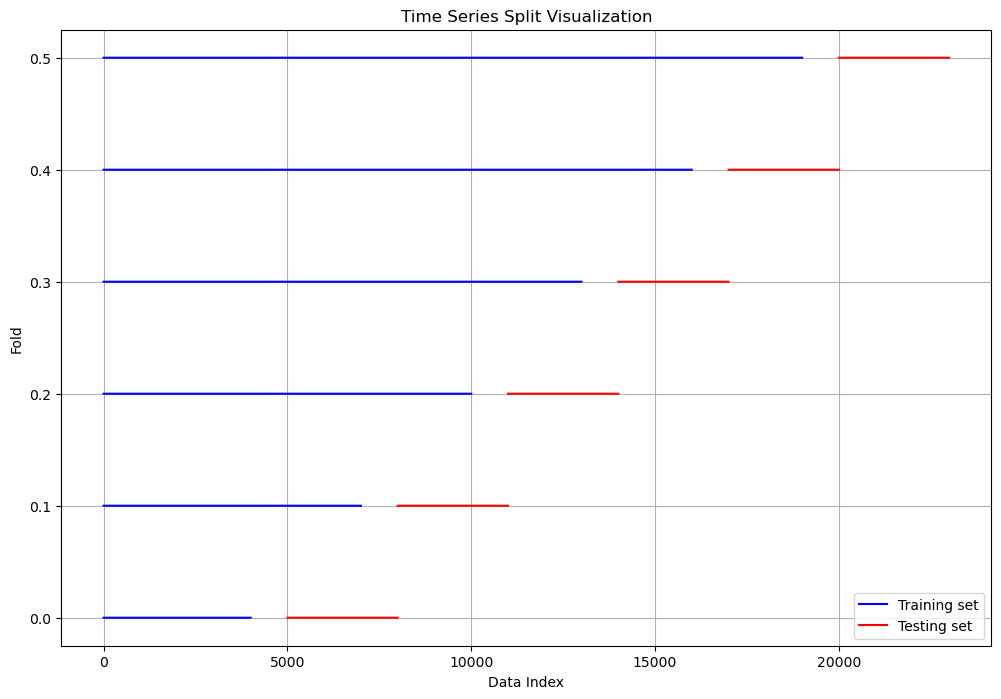

In [59]:
tscv_eg = TimeSeriesSplit(n_splits=6, test_size=3000, gap=1000)

plot_time_series_splits(23000, tscv_eg)

In [ ]:
results_expanding_gap_no_smote = boosting_model(X_train_smote, y_train_smote, tscv_eg, hyperparameters, False)

In [65]:
# save
results_expanding_gap_no_smote.to_csv('results_expanding_gap_no_smote.csv', index=False)

In [ ]:
results_expanding_gap_smote = boosting_model(X_train_smote, y_train_smote, tscv_eg, hyperparameters, True)

In [84]:
# export
results_expanding_gap_smote.to_csv('results_expanding_gap_smote.csv', index=False)

## Ranking results

In [ ]:
# read in expanding fold yes gap yes SMOTE
results_expanding_yes_gap_yes_smote = pd.read_csv('results_expanding_gap_smote.csv')
results_expanding_yes_gap_yes_smote_df, results_expanding_yes_gap_yes_smote_exponential_df = cv_score_plus_exponential(results_expanding_yes_gap_yes_smote)

# read in expanding fold yes gap no SMOTE
results_expanding_yes_gap_no_smote = pd.read_csv('results_expanding_gap_no_smote.csv')
results_expanding_yes_gap_no_smote_df, results_expanding_yes_gap_no_smote_exponential_df = cv_score_plus_exponential(results_expanding_yes_gap_no_smote)

In [ ]:
X_train_transformed = apply_preprocessor(X_train_smote, y_train_smote)

# now fit the model with the best hyperparameters
model = GradientBoostingClassifier(n_estimators=1000, max_depth=5, learning_rate=0.01, max_features='log2', random_state=808)

model.fit(X_train_transformed, y_train_smote)

## Results analysis

In [462]:
X_test_copy = X_test.copy()

X_test_copy = apply_preprocessor(X_test_copy, y_test)

X_test_copy.columns = X_test_copy.columns.str.replace('remainder__', '')
X_test_copy.columns = X_test_copy.columns.str.replace('log__', '')
X_test_copy.columns = X_test_copy.columns.str.replace('sqrt__', '')

indices = [X_test_copy.columns.get_loc(col) for col in ['number_of_employees_max', 'usd_a', 'investors_a', 'money_per_investor_series_a', 'age_series_a', 'time_between_rounds', 'founded_year', 'number_of_founders', 't_studying_sum', 'degrees_per_founder_started']]

In [ ]:
explainer = shap.Explainer(model)

X_test_transformed = apply_preprocessor(X_test, y_test)

shap_values = explainer.shap_values(X_test_transformed)

X_test_transformed_copy = X_test_transformed.copy()

X_test_transformed_copy.columns = X_test_transformed_copy.columns.str.replace('remainder__', '')
X_test_transformed_copy.columns = X_test_transformed_copy.columns.str.replace('log__', '')
X_test_transformed_copy.columns = X_test_transformed_copy.columns.str.replace('sqrt__', '')

shap_values = shap_values[:, indices]

X_test_transformed_copy = X_test_transformed_copy.iloc[:, indices]

shap.summary_plot(shap_values, X_test_transformed_copy)

In [ ]:
X_test_transformed = apply_preprocessor(X_test, y_test)

y_pred = model.predict(X_test_transformed)

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

print(roc_auc_score(y_test, y_pred))

In [394]:
X_importances = X_train_transformed.copy()

In [398]:
X_importances.columns = [col.replace('log__', '').replace('sqrt__', '').replace('remainder__', '').replace('sin__', '').replace('target__', '') for col in X_importances.columns]

In [ ]:
# build a df with two columns - one holds the feature names, the other the feature importances
feature_importance_df = pd.DataFrame({'feature': X_importances.columns, 'importance': feature_importance})

feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

# add up all importances of the different categories into one
categories = ['Media and Entertainment', 'Technology', 'Commerce and Business', 'Social and Community Services',
       'Health and Life Sciences', 'Environmental and Sustainability',
       'Design and Creativity', 'Transportation and Travel',
       'Food and Beverage', 'Miscellaneous', 'Sports', 'Software',
       'GovAndMilitary', 'Biotechnology']

category_importances = feature_importance_df[feature_importance_df['feature'].isin(categories)]['importance'].sum()

# now delete the individual importances
feature_importance_df = feature_importance_df[~feature_importance_df['feature'].isin(categories)]

# add the category importances as a row to the df
category_importance_df = pd.DataFrame({'feature': 'industry', 'importance': category_importances}, index=[0])

feature_importance_df = pd.concat([feature_importance_df, category_importance_df])

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# plot the feature importances
plt.figure(figsize=(20, 12))
sns.barplot(data=feature_importance_df, x='importance', y='feature', color='#4878CF')
plt.title('Feature Importances')
plt.ylabel('')
plt.tight_layout()
#plt.savefig('feature_importances.png')
plt.show()

In [425]:
# Among previous funding rounds, organizational factors, and founding team background, which area has the largest impact on predictions? Which the lowest?
# To answer the above research question, the previous variable importances have to be aggregated into the three categories (or other)

funding_rounds_vars = ['usd_a', 'state_code_series_a', 'series_a_year', 'investors_a', 'money_per_investor_series_a', 'time_between_rounds', 'series_a_dayofyear',
                       'acc_inv_pre_series_a', 'money_per_investor_pre_series_a', 'acc_usd_pre_series_a', 'angel', 'number_of_funding_rounds', 'series_a_month', 
                       'series_a_quarter', 'seed', 'pre_seed']

organizational_vars = ['number_of_employees_max', 'industry', 'age_series_a', 'country_code', 'founded_year', 'foundation_dayofyear', 'founded_month', 'founded_quarter']

founding_team_vars = ['number_of_founders', 't_studying_sum', 'degrees_per_founder_started', 'p_male', 't_studying_mean', 'degrees_started', 'degrees_per_founder_completed',
                      'had_founders_information', 't_studying_per_degree_mean', 'tdelta_gradution_founding_min', 'tdelta_gradution_founding_max', 'tdelta_gradution_founding_mean',
                      'nationality_entropy', 'degrees_completed', 'had_study_information', 'number_of_companies_founded_before_mean', 'coding_experience', 
                      'number_of_companies_founded_before_max', 'business_experience', 'number_of_successful_companies_founded_before_mean', 'success_ratio_max',
                      'success_ratio_mean', 'number_of_companies_founded_before_min', 'number_of_successful_companies_founded_before_max']

In [428]:
degree_vars = ['t_studying_sum', 'degrees_per_founder_started', 't_studying_mean', 'degrees_started', 'degrees_per_founder_completed', 't_studying_per_degree_mean', 
                       'tdelta_gradution_founding_min', 'tdelta_gradution_founding_max', 'tdelta_gradution_founding_mean', 'degrees_completed', 'had_study_information',
                       'coding_experience', 'business_experience']

team_composition_vars = ['number_of_founders', 'p_male', 'had_founders_information', 'nationality_entropy']

professional_experience_vars = ['number_of_companies_founded_before_mean', 'number_of_companies_founded_before_max', 'number_of_successful_companies_founded_before_min',
                                'number_of_successful_companies_founded_before_max', 'success_ratio_mean', 'success_ratio_max', 'number_of_companies_founded_before_min']

In [431]:
date_vars = ['founded_year', 'foundation_dayofyear', 'founded_month', 'founded_quarter']

company_stats_vars = ['number_of_employees_max', 'industry', 'age_series_a', 'country_code']

In [432]:
money_vars = ['usd_a', 'investors_a', 'money_per_investor_series_a', 'acc_inv_pre_series_a', 'money_per_investor_pre_series_a', 'acc_usd_pre_series_a']

time_vars = ['time_between_rounds', 'series_a_dayofyear', 'series_a_month', 'series_a_quarter', 'series_a_year']

basic_vars = ['state_code_series_a', 'angel', 'seed', 'pre_seed', 'number_of_funding_rounds']



In [ ]:

# Calculate importances for organizational information subcategories
date_importance = feature_importance_df[feature_importance_df['feature'].isin(date_vars)]['importance'].sum()
company_stats_importance = feature_importance_df[feature_importance_df['feature'].isin(company_stats_vars)]['importance'].sum()
organizational_importance = date_importance + company_stats_importance

# Calculate importances for funding rounds subcategories
money_importance = feature_importance_df[feature_importance_df['feature'].isin(money_vars)]['importance'].sum()
time_importance = feature_importance_df[feature_importance_df['feature'].isin(time_vars)]['importance'].sum()
basic_importance = feature_importance_df[feature_importance_df['feature'].isin(basic_vars)]['importance'].sum()
funding_rounds_importance = money_importance + time_importance + basic_importance

# Calculate importances for founding team subcategories
degree_importance = feature_importance_df[feature_importance_df['feature'].isin(degree_vars)]['importance'].sum()
team_composition_importance = feature_importance_df[feature_importance_df['feature'].isin(team_composition_vars)]['importance'].sum()
professional_experience_importance = feature_importance_df[feature_importance_df['feature'].isin(professional_experience_vars)]['importance'].sum()
founding_team_importance = degree_importance + team_composition_importance + professional_experience_importance

# Create DataFrame for plotting
categories = ['Funding Rounds', 'Organizational', 'Founding Team']
importances = [funding_rounds_importance, organizational_importance, founding_team_importance]

# Create subcategory lists for stacked bar plot
funding_subcategories = [money_importance, time_importance, basic_importance]
organizational_subcategories = [date_importance, company_stats_importance]
founding_team_subcategories = [degree_importance, team_composition_importance, professional_experience_importance]

# Define labels for the legend
funding_labels = ['Investment Amount', 'Timing of Rounds', 'Funding Round Basics']
organizational_labels = ['Founding Dates', 'Company Characteristics']
founding_team_labels = ['Educational Background', 'Team Demographics', 'Entrepreneurial Experience']

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(categories, importances, color='gray', edgecolor='black')

# Adding subcategories to the Funding Rounds bar
bottom_funding = 0
funding_colors = sns.color_palette('rocket', len(funding_subcategories))
for i, (sub_importance, label) in enumerate(zip(funding_subcategories, funding_labels)):
    plt.bar('Funding Rounds', sub_importance, bottom=bottom_funding, label=label, color=funding_colors[i], edgecolor='black')
    bottom_funding += sub_importance

# Adding subcategories to the Organizational bar
bottom_organizational = 0
organizational_colors = sns.color_palette('mako', len(organizational_subcategories))
for i, (sub_importance, label) in enumerate(zip(organizational_subcategories, organizational_labels)):
    plt.bar('Organizational', sub_importance, bottom=bottom_organizational, label=label, color=organizational_colors[i], edgecolor='black')
    bottom_organizational += sub_importance

# Adding subcategories to the Founding Team bar
bottom_founding = 0
founding_colors = sns.color_palette('ch:s=-.2,r=.6', len(founding_team_subcategories))
for i, (sub_importance, label) in enumerate(zip(founding_team_subcategories, founding_team_labels)):
    plt.bar('Founding Team', sub_importance, bottom=bottom_founding, label=label, color=founding_colors[i], edgecolor='black')
    bottom_founding += sub_importance

# Customize plot
plt.title('Variable Importances by Category')
plt.ylabel('Importance')
plt.legend(title='Subcategories')
plt.tight_layout()
#plt.savefig('variable_importances_by_category.png')
plt.show()


# Reliability score

In [ ]:

reliability_df = pd.read_csv('modelling_df.csv')

normal_cols = [col for col in reliability_df.columns if col not in ['state_code_series_a', 'country_code', 'successful']]

normal_cols = ["remainder__" + col for col in normal_cols if col not in sin_transformer_cols]

target_cols = ['target__state_code_series_a', 'target__country_code']

sin_cols = ["sin__" + col for col in sin_transformer_cols]
y, X = reliability_df['successful'], reliability_df.drop(columns=['successful'])

X_NN, X_reliability_obs, y_train_reliability, y_reliability_obs = train_test_split(X, y, test_size=0.18055, shuffle=False)

sin_transformer = FunctionTransformer(np.sin, validate=False)
normal_scaler = StandardScaler()
target_scaler = StandardScaler()
sin_scaler = StandardScaler()
# First column transformer for transformations and imputation
preprocessor_transformations_reliability = ColumnTransformer(
    transformers=[
        ('target', TargetEncoder(handle_unknown='ignore'), dummy_cols),
        ('sin', sin_transformer, sin_transformer_cols)
    ],
    remainder='passthrough'
)

preprocessor_transformations_reliability.set_output(transform='pandas')

preprocessor_scaling_reliability = ColumnTransformer(
    transformers=[
        ('scale_all', normal_scaler, normal_cols),
        ('scale_target', target_scaler, target_cols),
        ('scale_sin', sin_scaler, sin_cols)
    ],
    remainder='passthrough' 
)

preprocessor_scaling_reliability.set_output(transform='pandas')

def apply_preprocessor_reliability(X, y):
    X_rea = preprocessor_transformations_reliability.fit_transform(X, y)
    X_re = preprocessor_scaling_reliability.fit_transform(X_rea, y)
    return X_re
feature_space = apply_preprocessor_reliability(X_NN, y_train_reliability)
X_reliability_obs = apply_preprocessor_reliability(X_reliability_obs, y_reliability_obs)
X_reliability_obs['is_test'] = 1
feature_space['is_test'] = 0
feature_space2 = pd.concat([feature_space, X_reliability_obs])

k = 10
knn = NearestNeighbors(n_neighbors=k, metric='euclidean')

knn.fit(feature_space)

distances, indices = knn.kneighbors(feature_space2)

certainties = []

for i in range(len(indices)):
    certainty = y_train_reliability.iloc[indices[i]].mean()
    if certainty < 0.5:
        certainty = (1 - certainty)
    certainties.append(y_train_reliability.iloc[indices[i]].mean())

mean_distances = []

for i in range(len(distances)):
    mean_distances.append(distances[i].mean())

median_distances = []

for i in range(len(distances)):
    median_distances.append(np.median(distances[i]))

distance_sums = []    

for i in range(len(distances)):
    distance_sums.append(distances[i].sum())

# lets build reliability_df that for each observation of the test set holds the certainties, mean_distances, median_distances and distance_sums
reliability_measures = pd.DataFrame({'certainties': certainties, 'mean_distances': mean_distances, 'median_distances': median_distances, 
                                     'distance_sums': distance_sums, 'is_test': feature_space2['is_test']})

reliability_df = reliability_measures.copy()

# discard the last 2068 observations
reliability_df = reliability_df[reliability_df['is_test'] == 1]
reliability_df.drop(columns=['is_test'], inplace=True)

reliability_df['certainties_percentiles'] = reliability_df['certainties'].rank(pct=True)
reliability_df['mean_distances_percentiles'] = reliability_df['mean_distances'].rank(pct=True)
reliability_df['median_distances_percentiles'] = reliability_df['median_distances'].rank(pct=True)
reliability_df['distance_sums_percentiles'] = reliability_df['distance_sums'].rank(pct=True)

reliability_df.drop(columns=['certainties', 'mean_distances', 'median_distances', 'distance_sums'], inplace=True)

preprocessor_log = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p, validate=False), reliability_df.columns)
    ],
    remainder='passthrough'
)

preprocessor_log.set_output(transform='pandas')

reliability_df1 = preprocessor_log.fit_transform(reliability_df)

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=2), reliability_df1.columns)
    ],
    remainder='passthrough'
)

preprocessor_poly.set_output(transform='pandas')

reliability_df2 = preprocessor_poly.fit_transform(reliability_df1)

preprocessor_standard = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), reliability_df2.columns)
    ],
    remainder='passthrough'
)

preprocessor_standard.set_output(transform='pandas')

reliability_final = preprocessor_standard.fit_transform(reliability_df2)

In [ ]:
reliability_final['residual'] = (y_reliability_obs - y_pred).abs()

X_train_reliability, X_test_reliability, y_train_reliability, y_test_reliability = train_test_split(reliability_final.drop(columns=['residual']), reliability_final['residual'], test_size=0.40805, random_state=808)

SMOTER = SMOTE(sampling_strategy=1.0, random_state=808)

X_train_reliability_smote, y_train_reliability_smote = SMOTER.fit_resample(X_train_reliability, y_train_reliability)

log_reg = LogisticRegression(random_state=808, max_iter=1000000)

log_reg.fit(X_train_reliability_smote, y_train_reliability_smote)

y_pred_reliability = log_reg.intercept_ + np.dot(X_test_reliability, log_reg.coef_.T)

X_test_reliability['y_pred_reliability'] = 1 / (1 + np.exp(-y_pred_reliability))

bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['blue', 'green', 'yellow', 'orange', 'red']

X_test_reliability['percentile_prediction'] = X_test_reliability['y_pred_reliability'].rank(pct=True)

X_test_reliability['color'] = pd.cut(X_test_reliability['percentile_prediction'], bins=bins, labels=labels)

X_test_reliability['is_residual'] = y_test_reliability

prediction_certainties_final = X_test_reliability[['color', 'is_residual']]

cross_tab = pd.crosstab(prediction_certainties_final['color'], prediction_certainties_final['is_residual'], normalize='index')
cross_tab = cross_tab.reindex(labels[::-1])
ax = cross_tab.plot(kind='bar', stacked=False)

ax.legend(loc='upper right', title='is_residual', bbox_to_anchor=(1.1, 1))

plt.title('Proportion of Prediction Reliability by Residual')
plt.xlabel('Prediction Reliability')
plt.ylabel('Proportion')
plt.show()

In [ ]:
# lets access the weights
weights = log_reg.coef_

# connect the weights to the feature names
feature_names = reliability_final.columns

# remove residual
feature_names = feature_names.drop('residual')

# create a df with the feature names and the weights
feature_weights = pd.DataFrame({'feature': feature_names, 'weight': weights[0]})

# sort the df by the weights
feature_weights = feature_weights.sort_values(by='weight', ascending=False)

# plot the feature weights
plt.figure(figsize=(20, 12))
sns.barplot(data=feature_weights, x='weight', y='feature', color='#4878CF')
plt.title('Feature Weights')
plt.ylabel('')
plt.tight_layout()
#plt.savefig('feature_weights.png')
plt.show()

In [ ]:
# number of predictions per color
prediction_certainties_final['color'].value_counts()

In [ ]:
chi2, p, dof, expected = chi2_contingency(pd.crosstab(X_test_reliability['color'], X_test_reliability['is_residual']))

print(f"Chi-square test statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

alpha = 0.05
if p < alpha:
    print("There is a statistically significant difference between the proportions in the different groups.")
else:
    print("There is no statistically significant difference between the proportions in the different groups.")

In [ ]:
residuals_non_abs = (y_reliability_obs - y_pred)

X_train_reliability, X_test_reliability, y_train_reliability, residuals_non_absolute = train_test_split(reliability_final.drop(columns=['residual']), residuals_non_abs, test_size=0.40805, random_state=808)

prediction_certainties_final['non_abs_residual'] = residuals_non_absolute
# rename non_abs_residual to type I error, type II error and correct
prediction_certainties_final['non_abs_residual'] = prediction_certainties_final['non_abs_residual'].apply(lambda x: 'Type I error' if x == -1 else ('Type II error' if x == 1 else 'Correct'))

cross_tab = pd.crosstab(prediction_certainties_final['color'], prediction_certainties_final['non_abs_residual'], normalize='index')

# run a chi2 test
chi2, p, dof, expected = chi2_contingency(cross_tab)

print(f"Chi-square test statistic: {chi2}")
print(f"P-value: {p}")

# visualize the cross tab
cross_tab = cross_tab.reindex(labels[::-1])
ax = cross_tab.plot(kind='bar', stacked=False)

# Move legend to the bottom right corner
ax.legend(loc='upper right', title='non_abs_residual', bbox_to_anchor=(1.1, 1))

plt.title('Proportion of Prediction Reliability by Residual')
plt.xlabel('Prediction Reliability')
plt.ylabel('Proportion')
plt.show()

